In [37]:
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from functools import reduce
from sklearn.model_selection import GridSearchCV
from statistics import mean, stdev
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import TomekLinks
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
from scipy.interpolate import splrep, splev
from scipy.interpolate import make_interp_spline

In [2]:
all_merged = pd.read_csv('C:/Users/s3929438/all_features_mobile_100_all_final_latest.csv')

In [3]:
all_merged

,Unnamed: 0,User,sample,Error_rate_%,WPM,neg_UD_%,neg_UU_%,Other,mean_F1,mean_F2,...,mean_F3_is,mean_F4_is,mean_F1_co,mean_F2_co,mean_F3_co,mean_F4_co,mean_F1_le,mean_F2_le,mean_F3_le,mean_F4_le
0,0,100,1,23.0,31.875000,2.565283,0.000000,0,189.121212,313.484848,...,212.000000,355.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,100,10,13.0,34.545455,2.565283,0.000000,0,193.313131,329.585859,...,192.000000,385.000000,0.0,0.0,0.0,0.0,50.0,201.0,179.0,330.0
2,2,100,11,8.0,31.666667,3.030303,0.000000,0,208.505051,356.676768,...,174.000000,335.666667,0.0,0.0,0.0,0.0,76.0,215.0,205.0,344.0
3,3,100,12,16.0,36.000000,2.020202,0.000000,0,166.747475,299.787879,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,100,13,17.0,33.529412,2.020202,0.000000,0,206.555556,340.020202,...,156.666667,355.666667,0.0,0.0,0.0,0.0,40.5,185.0,162.5,307.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5354,5354,9,5,11.0,30.857143,1.010101,1.010101,0,245.383838,348.797980,...,169.000000,202.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5355,5355,9,6,7.0,37.500000,1.236858,0.000000,0,238.464646,316.232323,...,137.333333,213.666667,0.0,0.0,0.0,0.0,165.0,246.0,233.0,314.0
5356,5356,9,7,8.0,44.444444,1.236858,0.000000,0,184.070707,265.060606,...,115.000000,178.666667,0.0,0.0,0.0,0.0,39.0,100.0,113.0,174.0
5357,5357,9,8,7.0,22.500000,1.236858,0.000000,0,183.082474,264.082474,...,173.000000,236.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
selected_features = ['Error_rate_%', 'neg_UD_%', 'mean_F1', 'mean_F2', 'mean_F3', 'mean_F4',
       'Tri_graph', 'mean_hold_time', 'mean_F1_dis_0_LL', 'mean_F1_dis_1_LL',
       'mean_F1_dis_1_RR', 'mean_F1_dis_2_LL', 'mean_F1_dis_2_RR',
       'mean_F1_dis_3_LL', 'mean_F1_dis_3_RR', 'mean_F2_dis_0_LL',
       'mean_F2_dis_1_LL', 'mean_F2_dis_2_LL', 'mean_F2_dis_2_RR',
       'mean_F2_dis_3_LL', 'mean_F2_dis_3_RR', 'mean_F3_dis_0_LL',
       'mean_F3_dis_1_LL', 'mean_F3_dis_2_LL', 'mean_F3_dis_2_RR',
       'mean_F3_dis_3_LL', 'mean_F3_dis_3_RR', 'mean_F4_dis_0_LL',
       'mean_F4_dis_1_LL', 'mean_F4_dis_2_LL', 'mean_F4_dis_2_RR',
       'mean_F4_dis_3_LL', 'mean_F4_dis_3_RR', 'mean_F1_se', 'mean_F2_se',
       'mean_F3_se', 'mean_F4_se', 'mean_F1_th', 'mean_F2_th', 'mean_F3_th',
       'mean_F4_th']


# Applying optimal threshold for the fold

In [4]:
user = []
round_1_TP =[]
round_1_FP =[]
round_1_TN =[]
round_1_FN =[]
round_2_TP =[]
round_2_FP =[]
round_2_TN =[]
round_2_FN =[]
round_3_TP =[]
round_3_FP =[]
round_3_TN =[]
round_3_FN =[]
round_4_TP =[]
round_4_FP =[]
round_4_TN =[]
round_4_FN =[]
round_5_TP =[]
round_5_FP =[]
round_5_TN =[]
round_5_FN =[]


for a,i in enumerate (all_merged['User'].unique()):
# for i in range (1,10):
    user_set = all_merged[all_merged['User']==i]
    user_id = i
    
    all_set  = pd.DataFrame()
    
    for b,j in enumerate (all_merged['User'].unique()):
        if j != i:
            
            train_set = all_merged[all_merged['User']==j]
    
            all_set = all_set.append(train_set,ignore_index=True)
            
            
    user_set.insert(loc = len(user_set.columns),column = 'User_type',value = 1)
    all_set.insert(loc = len(all_set.columns),column = 'User_type',value = 0)
    
    final_set = user_set.append(all_set)
    
    x = final_set[selected_features]
    y = final_set['User_type']
    
    feature_names = (x.iloc[:,:]).columns.array
    
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    resample = SMOTE(random_state=42, sampling_strategy=0.2)

#     model_sl = xgb.XGBClassifier(
#                                     n_estimators = 1000, 
#                                     colsample_bytree = 0.3,
#                                     max_depth = 4,
#                                     min_child_weight=2                  
#     )

    model_sl = xgb.XGBClassifier(max_depth=3 ,colsample_bytree=0.5 ,min_child_weight =3 ,learning_rate=0.1, subsample =0.9, 
                                 scale_pos_weight= 0.7 )
 
    count_dict_TP = {}
    count_dict_FP = {}
    count_dict_TN = {}
    count_dict_FN = {}
    
    for j , (train_index , test_index) in enumerate (skf.split(x,y)):
        count_dict_TP['round_%s'%j]= []
        count_dict_FP['round_%s'%j]= []
        count_dict_TN['round_%s'%j]= []
        count_dict_FN['round_%s'%j]= []
        
        
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
        
        x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
     
        model_sl.fit(x_train_res,y_train_res)
        pred_values = model_sl.predict(X_test)
        predict_probs = model_sl.predict_proba(X_test)
        
        false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predict_probs[:, -1])
        
#         fig,ax = plt.subplots(figsize = (10,5))
#         plt.plot(false_pos_rate,true_pos_rate)
#         plt.show()
        
        optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), 
                                      key=lambda i: i[0], reverse=True)[0][1]
        
        roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in predict_probs[:, -1]]
     
        cnf_matrix = confusion_matrix(y_test, roc_predictions)
        TP = cnf_matrix[1][1] 
        FP = cnf_matrix[0][1]
        FN = cnf_matrix[1][0]
        TN = cnf_matrix[0][0]
      

        count_dict_TP['round_%s'%j].append(TP)
        count_dict_FP['round_%s'%j].append(FP)
        count_dict_TN['round_%s'%j].append(TN)
        count_dict_FN['round_%s'%j].append(FN)
  
    
    user.append(user_id)
    
    round_1_TP.append(count_dict_TP['round_0'][0])
    round_1_FP.append(count_dict_FP['round_0'][0])
    round_1_TN.append(count_dict_TN['round_0'][0])
    round_1_FN.append(count_dict_FN['round_0'][0])
    
    round_2_TP.append(count_dict_TP['round_1'][0])
    round_2_FP.append(count_dict_FP['round_1'][0])
    round_2_TN.append(count_dict_TN['round_1'][0])
    round_2_FN.append(count_dict_FN['round_1'][0])
    
    round_3_TP.append(count_dict_TP['round_2'][0])
    round_3_FP.append(count_dict_FP['round_2'][0])
    round_3_TN.append(count_dict_TN['round_2'][0])
    round_3_FN.append(count_dict_FN['round_2'][0])
    
    round_4_TP.append(count_dict_TP['round_3'][0])
    round_4_FP.append(count_dict_FP['round_3'][0])
    round_4_TN.append(count_dict_TN['round_3'][0])
    round_4_FN.append(count_dict_FN['round_3'][0])
    
    round_5_TP.append(count_dict_TP['round_4'][0])
    round_5_FP.append(count_dict_FP['round_4'][0])
    round_5_TN.append(count_dict_TN['round_4'][0])
    round_5_FN.append(count_dict_FN['round_4'][0])
    

Final_results_df_all = pd.DataFrame(list(zip(user,round_1_TP,round_1_FP, round_1_TN,round_1_FN, 
                                            round_2_TP,round_2_FP, round_2_TN,round_2_FN,
                                            round_3_TP,round_3_FP, round_3_TN,round_3_FN,
                                            round_4_TP,round_4_FP, round_4_TN,round_4_FN,
                                            round_5_TP,round_5_FP, round_5_TN,round_5_FN)),
        columns =['User','1_TP','1_FP','1_TN','1_FN','2_TP','2_FP','2_TN','2_FN', '3_TP','3_FP','3_TN','3_FN', 
                  '4_TP','4_FP','4_TN','4_FN','5_TP','5_FP','5_TN','5_FN'])

KeyboardInterrupt: 

In [6]:
Final_results_df_all

,User,1_TP,1_FP,1_TN,1_FN,2_TP,2_FP,2_TN,2_FN,3_TP,...,3_TN,3_FN,4_TP,4_FP,4_TN,4_FN,5_TP,5_FP,5_TN,5_FN
0,100,11,26,1035,0,11,7,1054,0,10,...,1058,0,10,21,1041,0,10,7,1054,0
1,101,9,46,1017,0,9,55,1008,0,9,...,907,0,7,26,1038,1,8,179,884,0
2,102,8,1,1062,1,9,77,986,0,9,...,1013,0,9,0,1063,0,9,0,1062,0
3,103,9,19,1043,1,10,204,858,0,9,...,991,1,9,35,1028,0,8,9,1053,1
4,104,8,0,1064,0,8,0,1064,0,7,...,1064,0,7,4,1061,0,7,0,1064,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,96,10,94,968,0,10,71,991,0,10,...,1030,0,9,83,979,1,9,59,1002,1
112,97,9,88,975,0,9,49,1014,0,8,...,845,0,7,18,1046,1,8,89,974,0
113,98,11,114,947,0,10,37,1024,1,11,...,1007,0,11,144,917,0,11,71,989,0
114,99,10,60,1002,0,10,53,1009,0,10,...,988,0,9,38,1024,1,10,65,996,0


In [ ]:
df_count =  Final_results_df_all.sum()

In [ ]:
Acc_1 = (df_count[1] + df_count[3])/(df_count[1] + df_count[3] + df_count[2] + df_count[4])
Acc_2 = (df_count[5] + df_count[7])/(df_count[5] + df_count[7] + df_count[6] + df_count[8])
Acc_3 = (df_count[9] + df_count[11])/(df_count[9] + df_count[11] + df_count[10] + df_count[12])
Acc_4 = (df_count[13] + df_count[15])/(df_count[13] + df_count[15] + df_count[14] + df_count[16])
Acc_5 = (df_count[17] + df_count[19])/(df_count[17] + df_count[19] + df_count[18] + df_count[20])

Prec1 = (df_count[1])/(df_count[1] + df_count[2])
Prec2 = (df_count[5])/(df_count[5] + df_count[6])
Prec3 = (df_count[9])/(df_count[9] + df_count[10])
Prec4 = (df_count[13])/(df_count[13] + df_count[14])
Prec5 = (df_count[17])/(df_count[17] + df_count[18])

Rec1 = (df_count[1])/(df_count[1] + df_count[4])
Rec2 = (df_count[5])/(df_count[5] + df_count[8])
Rec3 = (df_count[9])/(df_count[9] + df_count[12])
Rec4 = (df_count[13])/(df_count[13] + df_count[16])
Rec5 = (df_count[17])/(df_count[17] + df_count[20])

F1_1 = 2*(Prec1 * Rec1)/(Prec1 + Rec1)
F1_2 = 2*(Prec2 * Rec2)/(Prec2 + Rec2)
F1_3 = 2*(Prec3 * Rec3)/(Prec3 + Rec3)
F1_4 = 2*(Prec4 * Rec4)/(Prec4 + Rec4)
F1_5 = 2*(Prec5 * Rec5)/(Prec5 + Rec5)

FAR1 = (df_count[2])/(df_count[3] + df_count[2])
FAR2 = (df_count[6])/(df_count[7] + df_count[6])
FAR3 = (df_count[10])/(df_count[11] + df_count[10])
FAR4 = (df_count[14])/(df_count[15] + df_count[14])
FAR5 = (df_count[18])/(df_count[19] + df_count[18])

FRR1 = (df_count[4])/(df_count[1] + df_count[4])
FRR2 = (df_count[8])/(df_count[5] + df_count[8])
FRR3 = (df_count[12])/(df_count[9] + df_count[12])
FRR4 = (df_count[16])/(df_count[13] + df_count[16])
FRR5 = (df_count[20])/(df_count[17] + df_count[20])

In [ ]:
Round1 = [Acc_1, Prec1, Rec1, F1_1, FAR1,FRR1]
Round2 = [Acc_2, Prec2, Rec2, F1_2, FAR2,FRR2]
Round3 = [Acc_3, Prec3, Rec3, F1_3, FAR3,FRR3]
Round4 = [Acc_4, Prec4, Rec4, F1_4, FAR4,FRR4]
Round5 = [Acc_5, Prec5, Rec5, F1_5, FAR5,FRR5]

In [ ]:
df_all = pd.DataFrame([Round1, Round2, Round3, Round4, Round5], 
                      columns=('Accuracy', 'Precision', 'Recall', 'F1', 'FAR', 'FRR'))

In [ ]:
df_all

In [ ]:
df_all.mean()

In [ ]:

# for a,i in enumerate (all_merged['User'].unique()):
for i in range (1,2):
    user_set = all_merged[all_merged['User']==i]
    user_id = i
    
    all_set  = pd.DataFrame()
    
    for b,j in enumerate (all_merged['User'].unique()):
        if j != i:
            
            train_set = all_merged[all_merged['User']==j].sample(frac=0.75, random_state=42)
    
            all_set = all_set.append(train_set,ignore_index=True)
            
            
    user_set.insert(loc = len(user_set.columns),column = 'User_type',value = 1)
    all_set.insert(loc = len(all_set.columns),column = 'User_type',value = 0)
    
    final_set = user_set.append(all_set)
    
    x = final_set[selected_features]
    y = final_set['User_type']
    
    feature_names = (x.iloc[:,:]).columns.array
    
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    resample = SMOTE(random_state=42, sampling_strategy=0.2)

    model_sl = xgb.XGBClassifier(
#                                     n_estimators = 1000, 
#                                     colsample_bytree = 0.3,
#                                     max_depth = 4,
#                                     min_child_weight=2                  
    )

    
    for j , (train_index , test_index) in enumerate (skf.split(x,y)):
        
        
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
        
        x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
     
        model_sl.fit(x_train_res,y_train_res)
        pred_values = model_sl.predict(X_test)
        predict_probs = model_sl.predict_proba(X_test)
        
        false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predict_probs[:, -1])
        
        
        fig,ax = plt.subplots(figsize = (10,5))
        plt.plot(false_pos_rate,true_pos_rate)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

In [ ]:


# for a,i in enumerate (all_merged['User'].unique()):
for i in range (1,2):
    user_set = all_merged[all_merged['User']==i]
    user_id = i
    
    all_set  = pd.DataFrame()
    
    for b,j in enumerate (all_merged['User'].unique()):
        if j != i:
            
            train_set = all_merged[all_merged['User']==j]
            
            
            
            
            
    
            all_set = all_set.append(train_set,ignore_index=True)
            
            
    user_set.insert(loc = len(user_set.columns),column = 'User_type',value = 1)
    all_set.insert(loc = len(all_set.columns),column = 'User_type',value = 0)
    
    final_set = user_set.append(all_set)
    
    x = final_set[selected_features]
    y = final_set['User_type']
    
    feature_names = (x.iloc[:,:]).columns.array
    
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    resample = SMOTE(random_state=42, sampling_strategy=0.2)

    model_sl = xgb.XGBClassifier(
#                                     n_estimators = 1000, 
#                                     colsample_bytree = 0.3,
#                                     max_depth = 4,
#                                     min_child_weight=2                  
    )
 
    count_dict_TP = {}
    count_dict_FP = {}
    count_dict_TN = {}
    count_dict_FN = {}
    
    for j , (train_index , test_index) in enumerate (skf.split(x,y)):
        count_dict_TP['round_%s'%j]= []
        count_dict_FP['round_%s'%j]= []
        count_dict_TN['round_%s'%j]= []
        count_dict_FN['round_%s'%j]= []
        
        
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
        
        x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
     
        model_sl.fit(x_train_res,y_train_res)
        pred_values = model_sl.predict(X_test)
        predict_probs = model_sl.predict_proba(X_test)
        
        false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predict_probs[:, -1])
        
        
        fig,ax = plt.subplots(figsize = (10,5))
        plt.plot(proba,true_pos_rate)
        plt.plot(proba, (1-false_pos_rate))
        plt.xlabel('Threshold')
        plt.show()
        

In [ ]:

# for a,i in enumerate (all_merged['User'].unique()):
for i in range (1,2):
    user_set = all_merged[all_merged['User']==i]
    user_id = i
    
    all_set  = pd.DataFrame()
    
    for b,j in enumerate (all_merged['User'].unique()):
        if j != i:
            
            train_set = all_merged[all_merged['User']==j]
    
            all_set = all_set.append(train_set,ignore_index=True)
            
            
    user_set.insert(loc = len(user_set.columns),column = 'User_type',value = 1)
    all_set.insert(loc = len(all_set.columns),column = 'User_type',value = 0)
    
    final_set = user_set.append(all_set)
    
    x = final_set[selected_features]
    y = final_set['User_type']
    
    feature_names = (x.iloc[:,:]).columns.array
    
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    resample = SMOTE(random_state=42, sampling_strategy=0.2)

    model_sl = xgb.XGBClassifier(
#                                     n_estimators = 1000, 
#                                     colsample_bytree = 0.3,
#                                     max_depth = 4,
#                                     min_child_weight=2                  
    )
 
  
    folds={}
    df_names = []
    
    for j , (train_index , test_index) in enumerate (skf.split(x,y)):
            X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
        
            x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
     
            model_sl.fit(x_train_res,y_train_res)
            pred_values = model_sl.predict(X_test)
            predict_probs = model_sl.predict_proba(X_test)
        
            false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predict_probs[:, -1],pos_label=1)
            
            df_name = 'round'+'_'+ str(j)+'_df'
    
            folds[df_name] =  pd.DataFrame(zip(proba, false_pos_rate, true_pos_rate),columns = ["Threshold", "FPR","TPR"])
            df_names.append(df_name)
    

In [ ]:
df_first = pd.DataFrame.from_dict(folds[df_names[0]])

In [ ]:
df_first.to_csv('First_fold.csv')

In [ ]:
df_second.to_csv('Second_fold.csv')

In [ ]:
df_third.to_csv('Third_fold.csv')

In [ ]:
df_fourth.to_csv('Fourth_fold.csv')

In [ ]:
df_fifth.to_csv('Fifth_fold.csv')

# Checking the folds of single user

In [ ]:
user = []
average_fpr = []
average_tpr = []
average_thresh = []
average_resize = []
average_max_length = 0

# for a,i in enumerate (all_merged['User'].unique()):
for i in range (1,2):
    user_set = all_merged[all_merged['User']==i]
    user_id = i
    
    all_set  = pd.DataFrame()
    
    for b,j in enumerate (all_merged['User'].unique()):
        if j != i:
            
            train_set = all_merged[all_merged['User']==j]
    
            all_set = all_set.append(train_set,ignore_index=True)
            
            
    user_set.insert(loc = len(user_set.columns),column = 'User_type',value = 1)
    all_set.insert(loc = len(all_set.columns),column = 'User_type',value = 0)
    
    final_set = user_set.append(all_set)
    
    x = final_set[selected_features]
    y = final_set['User_type']
    
    feature_names = (x.iloc[:,:]).columns.array
    
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    resample = SMOTE(random_state=42, sampling_strategy=0.2)

    model_sl = xgb.XGBClassifier(
#                                     n_estimators = 1000, 
#                                     colsample_bytree = 0.3,
#                                     max_depth = 4,
#                                     min_child_weight=2                  
    )
 
  
 
    all_fpr = []
    all_tpr = []
    all_thresh = []
    resize_arys = []
    max_length = 0
    
  
    for s , (train_index , test_index) in enumerate (skf.split(x,y)):
            X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
        
            x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
     
            model_sl.fit(x_train_res,y_train_res)
            pred_values = model_sl.predict(X_test)
            predict_probs = model_sl.predict_proba(X_test)
            false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predict_probs[:, -1],pos_label=1)
            
            length = len(false_pos_rate)
            if length> max_length:
                max_length=length
                max_fold=s
                
                
            all_fpr.append(false_pos_rate)
            all_tpr.append(true_pos_rate)
            all_thresh.append(proba)
            
    longest_array_fpr = all_fpr[max_fold]
    longest_array_tpr = all_tpr[max_fold]
    longest_array_thresh = all_thresh[max_fold]
    
    indices =  np.arange(len(longest_array_fpr))

    resize_arys_fpr = []
    for a in range(len(all_fpr)):
        if a!= max_fold:
            short_array_fpr = all_fpr[a]
            interpolated_array_fpr = np.interp(indices, np.arange(len(short_array_fpr)), short_array_fpr)
            resize_arys_fpr.append(interpolated_array_fpr)
    
    resize_arys_tpr = []
    for b in range(len(all_tpr)):
        if b!= max_fold:
            short_array_tpr = all_tpr[b]
            interpolated_array_tpr = np.interp(indices, np.arange(len(short_array_tpr)), short_array_tpr)
            resize_arys_tpr.append(interpolated_array_tpr)
    
    resize_arys_thresh = []
    for c in range(len(all_thresh)):
        if c!= max_fold:
            short_array_thresh = all_thresh[c]
            interpolated_array_thresh = np.interp(indices, np.arange(len(short_array_thresh)), short_array_thresh)
            resize_arys_thresh.append(interpolated_array_thresh)
            
    all_folds_fpr =  []
    all_folds_fpr.append(longest_array_fpr)
    for arr1 in resize_arys_fpr:
        all_folds_fpr.append(arr1)
        
    all_folds_tpr =  []
    all_folds_tpr.append(longest_array_tpr)
    for arr2 in resize_arys_tpr:
        all_folds_tpr.append(arr2)
        
    all_folds_thrs =  []
    all_folds_thrs.append(longest_array_thresh)
    for arr3 in resize_arys_thresh:
        all_folds_thrs.append(arr3)
        
    avg_fpr = np.mean([all_folds_fpr[0], all_folds_fpr[1], all_folds_fpr[2], all_folds_fpr[3], all_folds_fpr[4]], axis=0)
    avg_tpr = np.mean([all_folds_tpr[0], all_folds_tpr[1], all_folds_tpr[2], all_folds_tpr[3], all_folds_tpr[4]], axis=0)
    avg_thresh = np.mean([all_folds_thrs[0], all_folds_thrs[1], all_folds_thrs[2], all_folds_thrs[3], 
                          all_folds_thrs[4]], axis=0)

final_per_user = pd.DataFrame(zip(avg_thresh, avg_fpr, avg_tpr),
                            columns = ["final_threshold", "final_FPR","final_TPR"])

In [ ]:
final_per_user.to_csv('average_user.csv')

# Checking for multiple users when getting the mean

In [ ]:
user = []
average_fpr = []
average_tpr = []
average_thresh = []
average_resize = []
average_max_length = 0

# for a,i in enumerate (all_merged['User'].unique()):
for i in range (1,4):
    user_set = all_merged[all_merged['User']==i]
    user_id = i
    
    all_set  = pd.DataFrame()
    
    for b,j in enumerate (all_merged['User'].unique()):
        if j != i:
            
            train_set = all_merged[all_merged['User']==j]
    
            all_set = all_set.append(train_set,ignore_index=True)
            
            
    user_set.insert(loc = len(user_set.columns),column = 'User_type',value = 1)
    all_set.insert(loc = len(all_set.columns),column = 'User_type',value = 0)
    
    final_set = user_set.append(all_set)
    
    x = final_set[selected_features]
    y = final_set['User_type']
    
    feature_names = (x.iloc[:,:]).columns.array
    
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    resample = SMOTE(random_state=42, sampling_strategy=0.2)

    model_sl = xgb.XGBClassifier(
#                                     n_estimators = 1000, 
#                                     colsample_bytree = 0.3,
#                                     max_depth = 4,
#                                     min_child_weight=2                  
    )
 
  
 
    all_fpr = []
    all_tpr = []
    all_thresh = []
    resize_arys = []
    max_length = 0
    
    for s , (train_index , test_index) in enumerate (skf.split(x,y)):
            X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
        
            x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
     
            model_sl.fit(x_train_res,y_train_res)
            pred_values = model_sl.predict(X_test)
            predict_probs = model_sl.predict_proba(X_test)
            false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predict_probs[:, -1],pos_label=1)
            
            length = len(false_pos_rate)
            if length> max_length:
                max_length=length
                max_fold=s
                
                
            all_fpr.append(false_pos_rate)
            all_tpr.append(true_pos_rate)
            all_thresh.append(proba)
            
    longest_array_fpr = all_fpr[max_fold]
    longest_array_tpr = all_tpr[max_fold]
    longest_array_thresh = all_thresh[max_fold]
    
    indices =  np.arange(len(longest_array_fpr))

    resize_arys_fpr = []
    for a in range(len(all_fpr)):
        if a!= max_fold:
            short_array_fpr = all_fpr[a]
            interpolated_array_fpr = np.interp(indices, np.arange(len(short_array_fpr)), short_array_fpr)
            resize_arys_fpr.append(interpolated_array_fpr)
    
    resize_arys_tpr = []
    for b in range(len(all_tpr)):
        if b!= max_fold:
            short_array_tpr = all_tpr[b]
            interpolated_array_tpr = np.interp(indices, np.arange(len(short_array_tpr)), short_array_tpr)
            resize_arys_tpr.append(interpolated_array_tpr)
    
    resize_arys_thresh = []
    for c in range(len(all_thresh)):
        if c!= max_fold:
            short_array_thresh = all_thresh[c]
            interpolated_array_thresh = np.interp(indices, np.arange(len(short_array_thresh)), short_array_thresh)
            resize_arys_thresh.append(interpolated_array_thresh)
            
    all_folds_fpr =  []
    all_folds_fpr.append(longest_array_fpr)
    for arr1 in resize_arys_fpr:
        all_folds_fpr.append(arr1)
        
    all_folds_tpr =  []
    all_folds_tpr.append(longest_array_tpr)
    for arr2 in resize_arys_tpr:
        all_folds_tpr.append(arr2)
        
    all_folds_thrs =  []
    all_folds_thrs.append(longest_array_thresh)
    for arr3 in resize_arys_thresh:
        all_folds_thrs.append(arr3)
        
    avg_fpr = np.mean([all_folds_fpr[0], all_folds_fpr[1], all_folds_fpr[2], all_folds_fpr[3], all_folds_fpr[4]], axis=0)
    avg_tpr = np.mean([all_folds_tpr[0], all_folds_tpr[1], all_folds_tpr[2], all_folds_tpr[3], all_folds_tpr[4]], axis=0)
    avg_thresh = np.mean([all_folds_thrs[0], all_folds_thrs[1], all_folds_thrs[2], all_folds_thrs[3], 
                          all_folds_thrs[4]], axis=0)
    
    avg_length = len(avg_fpr)
    if avg_length> average_max_length:
        average_max_length=avg_length
        avg_max_fold=user_id-1

    average_fpr.append(avg_fpr)
    average_tpr.append(avg_tpr)
    average_thresh.append(avg_thresh)

# Final version with mean values

In [ ]:
user = []
average_fpr = []
average_tpr = []
average_thresh = []
average_resize = []
average_max_length = 0

for a,i in enumerate (all_merged['User'].unique()):
# for i in range (1,5):
    user_set = all_merged[all_merged['User']==i]
    user_id = i
    
    all_set  = pd.DataFrame()
    
    for b,j in enumerate (all_merged['User'].unique()):
        if j != i:
            
            train_set = all_merged[all_merged['User']==j]
    
            all_set = all_set.append(train_set,ignore_index=True)
            
            
    user_set.insert(loc = len(user_set.columns),column = 'User_type',value = 1)
    all_set.insert(loc = len(all_set.columns),column = 'User_type',value = 0)
    
    final_set = user_set.append(all_set)
    
    x = final_set[selected_features]
    y = final_set['User_type']
    
    feature_names = (x.iloc[:,:]).columns.array
    
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    resample = SMOTE(random_state=42, sampling_strategy=0.2)

    model_sl = xgb.XGBClassifier(
#                                     n_estimators = 1000, 
#                                     colsample_bytree = 0.3,
#                                     max_depth = 4,
#                                     min_child_weight=2                  
    )
 
  
 
    all_fpr = []
    all_tpr = []
    all_thresh = []
    resize_arys = []
    max_length = 0
    
    for s , (train_index , test_index) in enumerate (skf.split(x,y)):
            X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
        
            x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
     
            model_sl.fit(x_train_res,y_train_res)
            pred_values = model_sl.predict(X_test)
            predict_probs = model_sl.predict_proba(X_test)
            false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predict_probs[:, -1],pos_label=1)
            
            length = len(false_pos_rate)
            if length> max_length:
                max_length=length
                max_fold=s
                
                
            all_fpr.append(false_pos_rate)
            all_tpr.append(true_pos_rate)
            all_thresh.append(proba)
            
    longest_array_fpr = all_fpr[max_fold]
    longest_array_tpr = all_tpr[max_fold]
    longest_array_thresh = all_thresh[max_fold]
    
    indices =  np.arange(len(longest_array_fpr))

    resize_arys_fpr = []
    for a in range(len(all_fpr)):
        if a!= max_fold:
            short_array_fpr = all_fpr[a]
            interpolated_array_fpr = np.interp(indices, np.arange(len(short_array_fpr)), short_array_fpr)
            resize_arys_fpr.append(interpolated_array_fpr)
    
    resize_arys_tpr = []
    for b in range(len(all_tpr)):
        if b!= max_fold:
            short_array_tpr = all_tpr[b]
            interpolated_array_tpr = np.interp(indices, np.arange(len(short_array_tpr)), short_array_tpr)
            resize_arys_tpr.append(interpolated_array_tpr)
    
    resize_arys_thresh = []
    for c in range(len(all_thresh)):
        if c!= max_fold:
            short_array_thresh = all_thresh[c]
            interpolated_array_thresh = np.interp(indices, np.arange(len(short_array_thresh)), short_array_thresh)
            resize_arys_thresh.append(interpolated_array_thresh)
            
    all_folds_fpr =  []
    all_folds_fpr.append(longest_array_fpr)
    for arr1 in resize_arys_fpr:
        all_folds_fpr.append(arr1)
        
    all_folds_tpr =  []
    all_folds_tpr.append(longest_array_tpr)
    for arr2 in resize_arys_tpr:
        all_folds_tpr.append(arr2)
        
    all_folds_thrs =  []
    all_folds_thrs.append(longest_array_thresh)
    for arr3 in resize_arys_thresh:
        all_folds_thrs.append(arr3)
        
    avg_fpr = np.mean([all_folds_fpr[0], all_folds_fpr[1], all_folds_fpr[2], all_folds_fpr[3], all_folds_fpr[4]], axis=0)
    avg_tpr = np.mean([all_folds_tpr[0], all_folds_tpr[1], all_folds_tpr[2], all_folds_tpr[3], all_folds_tpr[4]], axis=0)
    avg_thresh = np.mean([all_folds_thrs[0], all_folds_thrs[1], all_folds_thrs[2], all_folds_thrs[3], 
                          all_folds_thrs[4]], axis=0)
    
    avg_length = len(avg_fpr)
    if avg_length > average_max_length:
        average_max_length=avg_length
        

    average_fpr.append(avg_fpr)
    average_tpr.append(avg_tpr)
    average_thresh.append(avg_thresh)
    
for y in range (len(average_fpr)):
    size = len(average_fpr[y])
    if size == average_max_length:
        max_user_array = y
    
longest_avg_array_fpr = average_fpr[max_user_array]
longest_avg_array_tpr = average_tpr[max_user_array]
longest_avg_array_thresh = average_thresh[max_user_array]
    
avg_indices =  np.arange(len(longest_avg_array_fpr))

resize_arys_avg_fpr = []
for k in range(len(average_fpr)):
    if k!= max_user_array:
        short_array_avg_fpr = average_fpr[k]
        interpolated_array_avg_fpr = np.interp(avg_indices, np.arange(len(short_array_avg_fpr)), short_array_avg_fpr)
        resize_arys_avg_fpr.append(interpolated_array_avg_fpr)
    
resize_arys_avg_tpr = []
for n in range(len(average_tpr)):
    if n!= max_user_array:
        short_array_avg_tpr = average_tpr[n]
        interpolated_array_avg_tpr = np.interp(avg_indices, np.arange(len(short_array_avg_tpr)), short_array_avg_tpr)
        resize_arys_avg_tpr.append(interpolated_array_avg_tpr)
    
resize_arys_avg_thresh = []
for m in range(len(average_thresh)):
    if m!= max_user_array:
        short_array_avg_thresh = average_thresh[m]
        interpolated_array_avg_thresh = np.interp(avg_indices,np.arange(len(short_array_avg_thresh)),short_array_avg_thresh)
        resize_arys_avg_thresh.append(interpolated_array_avg_thresh)
            
all_folds_avg_fpr =  []
all_folds_avg_fpr.append(longest_avg_array_fpr)
for arr_avg1 in resize_arys_avg_fpr:
    all_folds_avg_fpr.append(arr_avg1)
        
all_folds_avg_tpr =  []
all_folds_avg_tpr.append(longest_avg_array_tpr)
for arr_avg2 in resize_arys_avg_tpr:
     all_folds_avg_tpr.append(arr_avg2)
        
all_folds_avg_thrs =  []
all_folds_avg_thrs.append(longest_avg_array_thresh)
for arr_avg3 in resize_arys_avg_thresh:
    all_folds_avg_thrs.append(arr_avg3)
        
final_average_fpr = np.mean(all_folds_avg_fpr, axis=0)
final_average_tpr = np.mean(all_folds_avg_tpr, axis=0)
final_average_thresh = np.mean(all_folds_avg_thrs, axis=0)

final_values = pd.DataFrame(zip(final_average_thresh, final_average_fpr, final_average_tpr),
                            columns = ["final_threshold", "final_FPR","final_TPR"])

In [ ]:
final_values['final_FNR'] = 1 - final_values['final_TPR']

In [ ]:
final_values

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(final_values['final_FPR'],final_values['final_TPR'])
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('ROC_for_mean.png')
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(final_values['final_FPR'],final_values['final_FNR'])
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
plt.savefig('det_curve_for_mean.png')
plt.show()

# Final version with median values

In [ ]:
user = []
median_fpr = []
median_tpr = []
median_thresh = []
median_resize = []
median_max_length = 0

for a,i in enumerate (all_merged['User'].unique()):
# for i in range (1,5):
    user_set = all_merged[all_merged['User']==i]
    user_id = i
    
    all_set  = pd.DataFrame()
    
    for b,j in enumerate (all_merged['User'].unique()):
        if j != i:
            
            train_set = all_merged[all_merged['User']==j]
    
            all_set = all_set.append(train_set,ignore_index=True)
            
            
    user_set.insert(loc = len(user_set.columns),column = 'User_type',value = 1)
    all_set.insert(loc = len(all_set.columns),column = 'User_type',value = 0)
    
    final_set = user_set.append(all_set)
    
    x = final_set[selected_features]
    y = final_set['User_type']
    
    feature_names = (x.iloc[:,:]).columns.array
    
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    resample = SMOTE(random_state=42, sampling_strategy=0.2)

    model_sl = xgb.XGBClassifier(
#                                     n_estimators = 1000, 
#                                     colsample_bytree = 0.3,
#                                     max_depth = 4,
#                                     min_child_weight=2                  
    )
 
  
 
    all_fpr = []
    all_tpr = []
    all_thresh = []
    resize_arys = []
    max_length = 0
    
    for s , (train_index , test_index) in enumerate (skf.split(x,y)):
            X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
        
            x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
     
            model_sl.fit(x_train_res,y_train_res)
            pred_values = model_sl.predict(X_test)
            predict_probs = model_sl.predict_proba(X_test)
            false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predict_probs[:, -1],pos_label=1)
            
            length = len(false_pos_rate)
            if length> max_length:
                max_length=length
                max_fold=s
                
                
            all_fpr.append(false_pos_rate)
            all_tpr.append(true_pos_rate)
            all_thresh.append(proba)
            
    longest_array_fpr = all_fpr[max_fold]
    longest_array_tpr = all_tpr[max_fold]
    longest_array_thresh = all_thresh[max_fold]
    
    indices =  np.arange(len(longest_array_fpr))

    resize_arys_fpr = []
    for a in range(len(all_fpr)):
        if a!= max_fold:
            short_array_fpr = all_fpr[a]
            interpolated_array_fpr = np.interp(indices, np.arange(len(short_array_fpr)), short_array_fpr)
            resize_arys_fpr.append(interpolated_array_fpr)
    
    resize_arys_tpr = []
    for b in range(len(all_tpr)):
        if b!= max_fold:
            short_array_tpr = all_tpr[b]
            interpolated_array_tpr = np.interp(indices, np.arange(len(short_array_tpr)), short_array_tpr)
            resize_arys_tpr.append(interpolated_array_tpr)
    
    resize_arys_thresh = []
    for c in range(len(all_thresh)):
        if c!= max_fold:
            short_array_thresh = all_thresh[c]
            interpolated_array_thresh = np.interp(indices, np.arange(len(short_array_thresh)), short_array_thresh)
            resize_arys_thresh.append(interpolated_array_thresh)
            
    all_folds_fpr =  []
    all_folds_fpr.append(longest_array_fpr)
    for arr1 in resize_arys_fpr:
        all_folds_fpr.append(arr1)
        
    all_folds_tpr =  []
    all_folds_tpr.append(longest_array_tpr)
    for arr2 in resize_arys_tpr:
        all_folds_tpr.append(arr2)
        
    all_folds_thrs =  []
    all_folds_thrs.append(longest_array_thresh)
    for arr3 in resize_arys_thresh:
        all_folds_thrs.append(arr3)
        
    med_fpr = np.median([all_folds_fpr[0], all_folds_fpr[1], all_folds_fpr[2], all_folds_fpr[3], all_folds_fpr[4]], axis=0)
    med_tpr = np.median([all_folds_tpr[0], all_folds_tpr[1], all_folds_tpr[2], all_folds_tpr[3], all_folds_tpr[4]], axis=0)
    med_thresh = np.median([all_folds_thrs[0], all_folds_thrs[1], all_folds_thrs[2], all_folds_thrs[3], 
                          all_folds_thrs[4]], axis=0)
    
    med_length = len(med_fpr)
    if med_length > median_max_length:
        median_max_length=med_length
        

    median_fpr.append(med_fpr)
    median_tpr.append(med_tpr)
    median_thresh.append(med_thresh)
    
for y in range (len(median_fpr)):
    size = len(median_fpr[y])
    if size == median_max_length:
        max_user_array = y
    
longest_med_array_fpr = median_fpr[max_user_array]
longest_med_array_tpr = median_tpr[max_user_array]
longest_med_array_thresh = median_thresh[max_user_array]
    
med_indices =  np.arange(len(longest_med_array_fpr))

resize_arys_med_fpr = []
for k in range(len(median_fpr)):
    if k!= max_user_array:
        short_array_med_fpr = median_fpr[k]
        interpolated_array_med_fpr = np.interp(med_indices, np.arange(len(short_array_med_fpr)), short_array_med_fpr)
        resize_arys_med_fpr.append(interpolated_array_med_fpr)
    
resize_arys_med_tpr = []
for n in range(len(median_tpr)):
    if n!= max_user_array:
        short_array_med_tpr = median_tpr[n]
        interpolated_array_med_tpr = np.interp(med_indices, np.arange(len(short_array_med_tpr)), short_array_med_tpr)
        resize_arys_med_tpr.append(interpolated_array_med_tpr)
    
resize_arys_med_thresh = []
for m in range(len(median_thresh)):
    if m!= max_user_array:
        short_array_med_thresh = median_thresh[m]
        interpolated_array_med_thresh = np.interp(med_indices,np.arange(len(short_array_med_thresh)),short_array_med_thresh)
        resize_arys_med_thresh.append(interpolated_array_med_thresh)
            
all_folds_med_fpr =  []
all_folds_med_fpr.append(longest_med_array_fpr)
for arr_med1 in resize_arys_med_fpr:
    all_folds_med_fpr.append(arr_med1)
        
all_folds_med_tpr =  []
all_folds_med_tpr.append(longest_med_array_tpr)
for arr_med2 in resize_arys_med_tpr:
     all_folds_med_tpr.append(arr_med2)
        
all_folds_med_thrs =  []
all_folds_med_thrs.append(longest_med_array_thresh)
for arr_med3 in resize_arys_med_thresh:
    all_folds_med_thrs.append(arr_med3)
        
final_median_fpr = np.median(all_folds_med_fpr, axis=0)
final_median_tpr = np.median(all_folds_med_tpr, axis=0)
final_median_thresh = np.median(all_folds_med_thrs, axis=0)

final_values = pd.DataFrame(zip(final_median_thresh, final_median_fpr, final_median_tpr),
                            columns = ["final_threshold", "final_FPR","final_TPR"])

In [ ]:
final_values['final_FNR'] = 1 - final_values['final_TPR']

In [ ]:
final_values

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(final_values['final_FPR'],final_values['final_TPR'])
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('ROC_for_median.png')
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(final_values['final_FPR'],final_values['final_FNR'])
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
plt.savefig('DET_for_median.png')
plt.show()

# Final_version

In [23]:
round_1_prob = []
round_2_prob = []
round_3_prob = []
round_4_prob = []
round_5_prob = []

round_1_lbl = []
round_2_lbl = []
round_3_lbl = []
round_4_lbl = []
round_5_lbl = []

round_1_pred_lbl = []
round_2_pred_lbl = []
round_3_pred_lbl = []
round_4_pred_lbl = []
round_5_pred_lbl = []


for a,i in enumerate (all_merged['User'].unique()):
# for i in range (1,5):
        user_set = all_merged[all_merged['User']==i]
        user_id = i
    
        all_set  = pd.DataFrame()
    
        for b,j in enumerate (all_merged['User'].unique()):
            if j != i:
                train_set = all_merged[all_merged['User']==j]
                all_set = all_set.append(train_set,ignore_index=True)
            
            
        user_set.insert(loc = len(user_set.columns),column = 'User_type',value = 1)
        all_set.insert(loc = len(all_set.columns),column = 'User_type',value = 0)
    
        final_set = user_set.append(all_set)
    
        X = final_set[selected_features]
        y = final_set['User_type']
    
#         feature_names = (x.iloc[:,:]).columns.array
    
        k = 5
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        resample = SMOTE(random_state=42, sampling_strategy=0.2)

#         model_sl = xgb.XGBClassifier(n_estimators = 1000, colsample_bytree = 0.3,max_depth = 4,min_child_weight=2)
   
        model_sl = xgb.XGBClassifier(max_depth=5 ,colsample_bytree=0.5 ,min_child_weight =3 ,learning_rate=0.1, 
                                     subsample =0.9, scale_pos_weight= 0.7 )
        
        for s , (train_index , test_index) in enumerate (skf.split(X,y)):
            if s==0:
                fold_1 = []
                labels_1 = []
                pred_lbl1 = []
                X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
                y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
                x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
                model_sl.fit(x_train_res,y_train_res)
                pred_values = model_sl.predict(X_test)
                predict_probs = model_sl.predict_proba(X_test)
                true_label = y_test
        
                fold_1.append(predict_probs[:,-1].tolist())
                labels_1.append(true_label.to_list())
                pred_lbl1.append(pred_values.tolist())
            
            elif s==1:
                fold_2 = []
                labels_2 = []
                pred_lbl2 = []
                
                X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
                y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
                x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
                model_sl.fit(x_train_res,y_train_res)
                pred_values = model_sl.predict(X_test)
                predict_probs = model_sl.predict_proba(X_test)
                true_label = y_test
        
                fold_2.append(predict_probs[:,-1].tolist())
                labels_2.append(true_label.to_list())
                pred_lbl2.append(pred_values.tolist())
            
            elif s==2:
                fold_3 = []
                labels_3 = []
                pred_lbl3 = []
                X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
                y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
                x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
                model_sl.fit(x_train_res,y_train_res)
                pred_values = model_sl.predict(X_test)
                predict_probs = model_sl.predict_proba(X_test)
                true_label = y_test
        
                fold_3.append(predict_probs[:,-1].tolist())
                labels_3.append(true_label.to_list())
                pred_lbl3.append(pred_values.tolist())
            
            elif s==3:
                fold_4 = []
                labels_4 = []
                pred_lbl4 = []
                X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
                y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
                x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
                model_sl.fit(x_train_res,y_train_res)
                pred_values = model_sl.predict(X_test)
                predict_probs = model_sl.predict_proba(X_test)
                true_label = y_test
        
                fold_4.append(predict_probs[:,-1].tolist())
                labels_4.append(true_label.to_list())
                pred_lbl4.append(pred_values.tolist())
                
            elif s==4:
                fold_5 = []
                labels_5 = []
                pred_lbl5 = []
                X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
                y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
                x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
                model_sl.fit(x_train_res,y_train_res)
                pred_values = model_sl.predict(X_test)
                predict_probs = model_sl.predict_proba(X_test)
                true_label = y_test
        
                fold_5.append(predict_probs[:,-1].tolist())
                labels_5.append(true_label.to_list())
                pred_lbl5.append(pred_values.tolist())
                
        round_1_prob.append(fold_1[0])
        round_2_prob.append(fold_2[0])
        round_3_prob.append(fold_3[0])
        round_4_prob.append(fold_4[0])
        round_5_prob.append(fold_5[0])
        
        round_1_lbl.append(labels_1[0])
        round_2_lbl.append(labels_2[0])
        round_3_lbl.append(labels_3[0])
        round_4_lbl.append(labels_4[0])
        round_5_lbl.append(labels_5[0])
        
        round_1_pred_lbl.append(pred_lbl1[0])
        round_2_pred_lbl.append(pred_lbl2[0])
        round_3_pred_lbl.append(pred_lbl3[0])
        round_4_pred_lbl.append(pred_lbl4[0])
        round_5_pred_lbl.append(pred_lbl5[0])

In [24]:
# for a,x in enumerate (all_merged['User'].unique()):
for z in range (0,116):
    if z == 0:
        append_all_fold1 = round_1_prob[z]
        append_all_label1 = round_1_lbl[z]
        append_all_pred_label1 = round_1_pred_lbl[z]
    else:
        append_all_fold1 = append_all_fold1 + round_1_prob[z]
        append_all_label1 = append_all_label1 + round_1_lbl[z]
        append_all_pred_label1 = append_all_pred_label1 + round_1_pred_lbl[z]
        
# for a,x in enumerate (all_merged['User'].unique()):
for z in range (0,116):
    if z == 0:
        append_all_fold2 = round_2_prob[z]
        append_all_label2 = round_2_lbl[z]
        append_all_pred_label2 = round_2_pred_lbl[z]
    else:
        append_all_fold2 = append_all_fold2 + round_2_prob[z]
        append_all_label2 = append_all_label2 + round_2_lbl[z]
        append_all_pred_label2 = append_all_pred_label2 + round_2_pred_lbl[z]
        
# for a,x in enumerate (all_merged['User'].unique()):
for z in range (0,116):
    if z == 0:
        append_all_fold3 = round_3_prob[z]
        append_all_label3 = round_3_lbl[z]
        append_all_pred_label3 = round_3_pred_lbl[z]
    else:
        append_all_fold3 = append_all_fold3 + round_3_prob[z]
        append_all_label3 = append_all_label3 + round_3_lbl[z]
        append_all_pred_label3 = append_all_pred_label3 + round_3_pred_lbl[z]
        
# for a,x in enumerate (all_merged['User'].unique()):
for z in range (0,116):
    if z == 0:
        append_all_fold4 = round_4_prob[z]
        append_all_label4 = round_4_lbl[z]
        append_all_pred_label4 = round_4_pred_lbl[z]
    else:
        append_all_fold4 = append_all_fold4 + round_4_prob[z]
        append_all_label4 = append_all_label4 + round_4_lbl[z]
        append_all_pred_label4 = append_all_pred_label4 + round_4_pred_lbl[z]
        
# for a,x in enumerate (all_merged['User'].unique()):
for z in range (0,116):
    if z == 0:
        append_all_fold5 = round_5_prob[z]
        append_all_label5 = round_5_lbl[z]
        append_all_pred_label5 = round_5_pred_lbl[z]
    else:
        append_all_fold5 = append_all_fold5 + round_5_prob[z]
        append_all_label5 = append_all_label5 + round_5_lbl[z]
        append_all_pred_label5 = append_all_pred_label5 + round_5_pred_lbl[z]

In [25]:
Final_results_df_all = pd.DataFrame(list(zip(append_all_fold1,append_all_label1,append_all_fold2,append_all_label2,
                                             append_all_fold3,append_all_label3, append_all_fold4,append_all_label4,
                                             append_all_fold5, append_all_label5,append_all_pred_label1,append_all_pred_label2,
                                            append_all_pred_label3,append_all_pred_label4,append_all_pred_label5)),
        columns =['Fold_1_pro','Fold_1_tl', 'Fold_2_pro', 'Fold_2_tl','Fold_3_pro','Fold_3_tl','Fold_4_pro','Fold_4_tl',
                  'Fold_5_pro', 'Fold_5_tl','Fold_1_pl','Fold_2_pl','Fold_3_pl','Fold_4_pl','Fold_5_pl'])

In [26]:
Final_results_df_all

,Fold_1_pro,Fold_1_tl,Fold_2_pro,Fold_2_tl,Fold_3_pro,Fold_3_tl,Fold_4_pro,Fold_4_tl,Fold_5_pro,Fold_5_tl,Fold_1_pl,Fold_2_pl,Fold_3_pl,Fold_4_pl,Fold_5_pl
0,0.930289,1,0.101508,1,0.995452,1,0.994437,1,0.989759,1,1,0,1,1,1
1,0.981780,1,0.978719,1,0.988048,1,0.994159,1,0.994129,1,1,1,1,1,1
2,0.940290,1,0.960786,1,0.998262,1,0.913206,1,0.991318,1,1,1,1,1,1
3,0.879405,1,0.909419,1,0.111044,1,0.982881,1,0.991586,1,1,1,0,1,1
4,0.974599,1,0.997198,1,0.174685,1,0.791411,1,0.993528,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124231,0.001047,0,0.000493,0,0.000347,0,0.003345,0,0.000272,0,0,0,0,0,0
124232,0.001203,0,0.002712,0,0.000316,0,0.000471,0,0.000667,0,0,0,0,0,0
124233,0.000375,0,0.000193,0,0.000294,0,0.000581,0,0.000337,0,0,0,0,0,0
124234,0.000424,0,0.005478,0,0.002249,0,0.000217,0,0.000276,0,0,0,0,0,0


In [27]:
Final_results_df_all.to_csv('Probabilities_XGboost_mobile.csv')

In [28]:
Final_results_df_all = pd.read_csv('C:/Users/s3929438/Probabilities_XGboost_mobile.csv')

In [29]:
fpr1, tpr1, _ = roc_curve(Final_results_df_all.iloc[:,2], Final_results_df_all.iloc[:,1])
fpr2, tpr2, _ = roc_curve(Final_results_df_all.iloc[:,4], Final_results_df_all.iloc[:,3])
fpr3, tpr3, _ = roc_curve(Final_results_df_all.iloc[:,6], Final_results_df_all.iloc[:,5])
fpr4, tpr4, _ = roc_curve(Final_results_df_all.iloc[:,8], Final_results_df_all.iloc[:,7])
fpr5, tpr5, _ = roc_curve(Final_results_df_all.iloc[:,10], Final_results_df_all.iloc[:,9])

In [8]:
# fpr1, tpr1, _ = roc_curve(Final_results_df_all.iloc[:,1], Final_results_df_all.iloc[:,0])
# fpr2, tpr2, _ = roc_curve(Final_results_df_all.iloc[:,3], Final_results_df_all.iloc[:,2])
# fpr3, tpr3, _ = roc_curve(Final_results_df_all.iloc[:,5], Final_results_df_all.iloc[:,4])
# fpr4, tpr4, _ = roc_curve(Final_results_df_all.iloc[:,7], Final_results_df_all.iloc[:,6])
# fpr5, tpr5, _ = roc_curve(Final_results_df_all.iloc[:,9], Final_results_df_all.iloc[:,8])

In [30]:
fnr1 = [1-x for x in tpr1]
fnr2 = [1-x for x in tpr2]
fnr3 = [1-x for x in tpr3]
fnr4 = [1-x for x in tpr4]
fnr5 = [1-x for x in tpr5]

In [31]:
fpr_list = [fpr1, fpr2,fpr3,fpr4,fpr5]
tpr_list = [tpr1, tpr2,tpr3,tpr4,tpr5]
fnr_list = [fnr1, fnr2,fnr3,fnr4,fnr5]

In [32]:
max_length = max(len(fprs) for fprs in fpr_list)

In [33]:
for i in range(0,5):
    if len(fpr_list[i]) < max_length:
        fpr_list[i] = np.pad(fpr_list[i], (0, max_length - len(fpr_list[i])), constant_values=1)

In [34]:
for i in range(0,5):
    if len(tpr_list[i]) < max_length:
        tpr_list[i] = np.pad(tpr_list[i], (0, max_length - len(tpr_list[i])), constant_values=1)

In [35]:
for i in range(0,5):
    if len(fnr_list[i]) < max_length:
        fnr_list[i] = np.pad(fnr_list[i], (0, max_length - len(fnr_list[i])), constant_values=0)

In [135]:
# since the lengths of FPR are not matching we have to define threshold points and interpolate them
# thresholds = np.linspace(0,1,200)

# int_fpr_1 = interp1d(tpr1, fpr1)(thresholds)
# int_fpr_2 = interp1d(tpr2, fpr2)(thresholds)
# int_fpr_3 = interp1d(tpr3, fpr3)(thresholds)
# int_fpr_4 = interp1d(tpr4, fpr4)(thresholds)
# int_fpr_5 = interp1d(tpr5, fpr5)(thresholds)

# int_tpr_1 = interp1d(fpr1, tpr1)(thresholds)
# int_tpr_2 = interp1d(fpr2, tpr2)(thresholds)
# int_tpr_3 = interp1d(fpr3, tpr3)(thresholds)
# int_tpr_4 = interp1d(fpr4, tpr4)(thresholds)
# int_tpr_5 = interp1d(fpr5, tpr5)(thresholds)


In [15]:
mean_fpr = np.mean(fpr_list, axis=0)
mean_tpr = np.mean(tpr_list, axis=0)
mean_fnr = np.mean(fnr_list, axis=0)

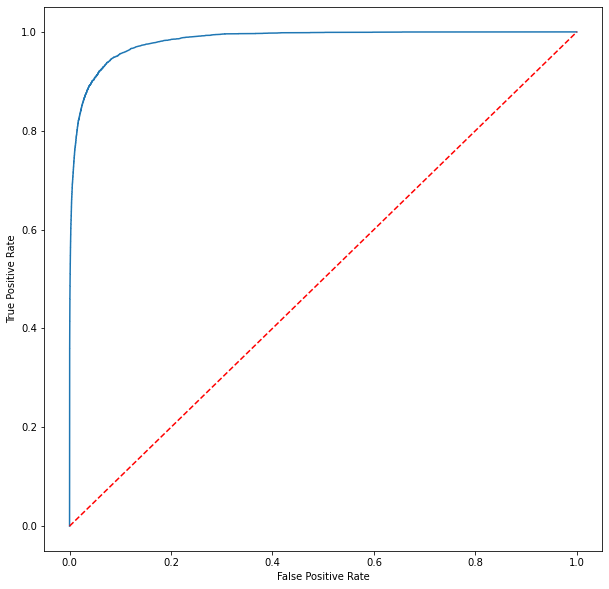

In [36]:
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(mean_fpr, mean_tpr)

plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

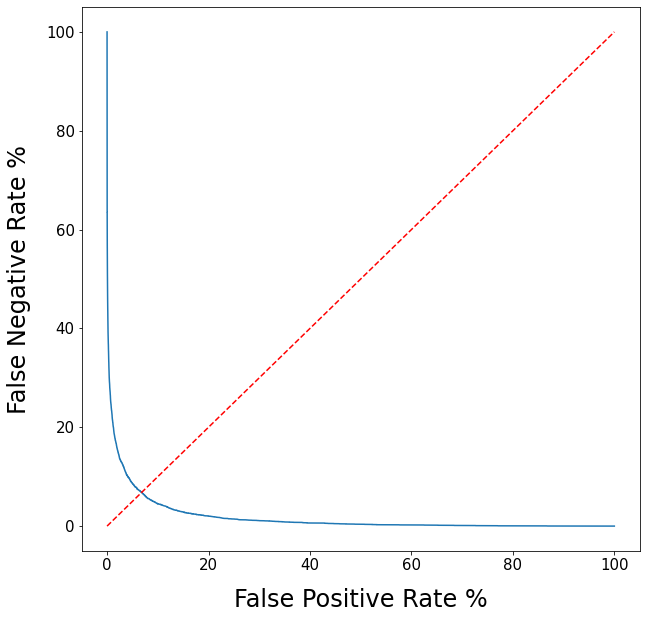

In [12]:
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(mean_fpr*100,mean_fnr*100)
plt.plot([0, 100], [0, 100],'r--')
ax.set_xlabel('False Positive Rate %', fontsize = 24, labelpad=15)
ax.set_ylabel('False Negative Rate %', fontsize = 24, labelpad=15)
ax.xaxis.set_tick_params(labelsize = 15)
ax.yaxis.set_tick_params(labelsize = 15)
# plt.savefig('DET_curve_mobile.png')
plt.show()

In [16]:
diff_values = [abs(fnr-fpr) for fnr, fpr in zip (mean_fnr, mean_fpr)]

In [17]:
min_diff_index = diff_values.index(min(diff_values))

In [18]:
eer_fnr = mean_fnr[min_diff_index]
eer_fpr = mean_fpr[min_diff_index]
eer = (eer_fnr + eer_fpr)/2

In [19]:
eer

0.06848409948951611

In [19]:
eer

0.06799904872096509

## AUC_ROC

In [38]:
fold_1_roc_auc = roc_auc_score(Final_results_df_all.iloc[:,2], Final_results_df_all.iloc[:,1])
fold_2_roc_auc = roc_auc_score(Final_results_df_all.iloc[:,4], Final_results_df_all.iloc[:,3])
fold_3_roc_auc = roc_auc_score(Final_results_df_all.iloc[:,6], Final_results_df_all.iloc[:,5])
fold_4_roc_auc = roc_auc_score(Final_results_df_all.iloc[:,8], Final_results_df_all.iloc[:,7])
fold_5_roc_auc = roc_auc_score(Final_results_df_all.iloc[:,10], Final_results_df_all.iloc[:,9])

In [39]:
mean_roc_auc = np.mean([fold_1_roc_auc,fold_2_roc_auc,fold_3_roc_auc,fold_4_roc_auc,fold_5_roc_auc])
std_roc_auc = np.std([fold_1_roc_auc,fold_2_roc_auc,fold_3_roc_auc,fold_4_roc_auc,fold_5_roc_auc])

In [40]:
mean_roc_auc

0.9837405789992246

In [41]:
std_roc_auc

0.002341494247286865

## Accuracy and F1

In [42]:
Fold_1_accuracy = metrics.accuracy_score(Final_results_df_all.iloc[:,2],Final_results_df_all.iloc[:,11])
Fold_1_f1 = metrics.f1_score(Final_results_df_all.iloc[:,2],Final_results_df_all.iloc[:,11])

In [43]:
Fold_2_accuracy = metrics.accuracy_score(Final_results_df_all.iloc[:,4],Final_results_df_all.iloc[:,12])
Fold_2_f1 = metrics.f1_score(Final_results_df_all.iloc[:,4],Final_results_df_all.iloc[:,12])

In [44]:
Fold_3_accuracy = metrics.accuracy_score(Final_results_df_all.iloc[:,6],Final_results_df_all.iloc[:,13])
Fold_3_f1 = metrics.f1_score(Final_results_df_all.iloc[:,6],Final_results_df_all.iloc[:,13])

In [45]:
Fold_4_accuracy = metrics.accuracy_score(Final_results_df_all.iloc[:,8],Final_results_df_all.iloc[:,14])
Fold_4_f1 = metrics.f1_score(Final_results_df_all.iloc[:,8],Final_results_df_all.iloc[:,14])

In [46]:
Fold_5_accuracy = metrics.accuracy_score(Final_results_df_all.iloc[:,10],Final_results_df_all.iloc[:,15])
Fold_5_f1 = metrics.f1_score(Final_results_df_all.iloc[:,10],Final_results_df_all.iloc[:,15])

In [47]:
mean_accuracy = np.mean([Fold_1_accuracy,Fold_2_accuracy,Fold_3_accuracy,Fold_4_accuracy,Fold_5_accuracy])
std_accuracy = np.std([Fold_1_accuracy,Fold_2_accuracy,Fold_3_accuracy,Fold_4_accuracy,Fold_5_accuracy])

In [48]:
mean_accuracy

0.9942786309926269

In [49]:
std_accuracy

8.779161083380438e-05

In [50]:
mean_f1 = np.mean([Fold_1_f1,Fold_2_f1,Fold_3_f1,Fold_4_f1,Fold_5_f1])
std_f1 = np.std([Fold_1_f1,Fold_2_f1,Fold_3_f1,Fold_4_f1,Fold_5_f1])

In [51]:
mean_f1

0.6359331921805342

In [52]:
std_f1

0.012267773705343515

## EER

In [53]:
diff_values1 = [abs(fnr-fpr) for fnr, fpr in zip (fnr1, fpr1)]
diff_values2 = [abs(fnr-fpr) for fnr, fpr in zip (fnr2, fpr2)]
diff_values3 = [abs(fnr-fpr) for fnr, fpr in zip (fnr3, fpr3)]
diff_values4 = [abs(fnr-fpr) for fnr, fpr in zip (fnr4, fpr4)]
diff_values5 = [abs(fnr-fpr) for fnr, fpr in zip (fnr5, fpr5)]

In [54]:
min_diff_index1 = diff_values1.index(min(diff_values1))
min_diff_index2 = diff_values2.index(min(diff_values2))
min_diff_index3 = diff_values3.index(min(diff_values3))
min_diff_index4 = diff_values4.index(min(diff_values4))
min_diff_index5 = diff_values5.index(min(diff_values5))

In [55]:
eer_fnr1 = fnr1[min_diff_index1]
eer_fpr1 = fpr1[min_diff_index1]
eer1 = (eer_fnr1 + eer_fpr1)/2

In [56]:
eer_fnr2 = fnr2[min_diff_index2]
eer_fpr2 = fpr2[min_diff_index2]
eer2 = (eer_fnr2 + eer_fpr2)/2

In [57]:
eer_fnr3 = fnr3[min_diff_index3]
eer_fpr3 = fpr3[min_diff_index3]
eer3 = (eer_fnr3 + eer_fpr3)/2

In [58]:
eer_fnr4 = fnr4[min_diff_index4]
eer_fpr4 = fpr4[min_diff_index4]
eer4 = (eer_fnr4 + eer_fpr4)/2

In [59]:
eer_fnr5 = fnr5[min_diff_index5]
eer_fpr5 = fpr5[min_diff_index5]
eer5 = (eer_fnr5 + eer_fpr5)/2

In [60]:
mean_eer = np.mean([eer1,eer2,eer3,eer4,eer5])
std_eer = np.std([eer1,eer2,eer3,eer4,eer5])

In [61]:
mean_eer

0.06658463200790318

In [62]:
std_eer

0.005150245793674658